In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#metriccs setting
g_loss_metrics = tf.metrics.Mean(name = 'g_loss')
d_loss_metrics = tf.metrics.Mean(name='d_loss')
total_loss_metrics = tf.metrics.Mean(name = 'total_loss')

In [3]:
#hyper_parameters
ITERATION = 1000
Z_DIM = 100
BATCH_SIZE = 512
BUFFER_SIZE = 60000
D_LR = 0.0002
G_LR = 0.0002
IMAGE_SHAPE = (28,28,1)
RANDOM_SEED = 42

In [4]:
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [5]:
test_z = tf.random.uniform([16,Z_DIM],minval=-1,maxval=1)

In [6]:
def get_random_z(batch_size,z_dim):
    return tf.random.uniform([batch_size,z_dim],minval=-1,maxval=1)

In [7]:
#define discriminator
def make_discriminator(input_shape):
    
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64,5,strides=2,padding='same',
                            input_shape=input_shape))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128,5,strides=2,padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

In [8]:
D = make_discriminator(IMAGE_SHAPE)
D.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0

In [9]:
#define generator
def make_generator(imput_shape):
    
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(7*7*256,use_bias=False,input_shape=imput_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7,7,256)))
    
    model.add(layers.Conv2DTranspose(128,5,strides=1,padding='same',
                                      use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64,5,strides=2,padding="same",
                                     use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1,5,strides=2,padding='same',
                                     use_bias=False,activation='tanh'))
    
    return model

In [10]:
G = make_generator((Z_DIM,))
G.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 128)        

In [11]:
def result_show(model,test_input):
    picture_g = model(test_input,training=False)
    fig = plt.figure(figsize = (4,4))
    for i in range(picture_g.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(picture_g[i],cmap='gray')
        plt.axis('off')
    plt.show()

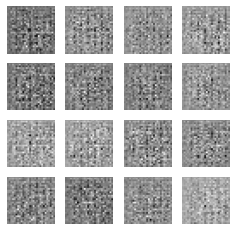

In [12]:
result_show(G,test_z)

In [13]:
#define loss function
def get_loss_fn():
    #Least Square Error
    criterion = tf.keras.losses.MeanSquaredError()
    
    def d_loss_fn(real_logits,fake_logits):
        real_loss = criterion(tf.ones_like(real_logits),real_logits)
        fake_loss = criterion(tf.zeros_like(fake_logits),fake_logits)
        return real_loss + fake_loss
        
    def g_loss_fn(fake_logits):
        return criterion(tf.ones_like(fake_logits),fake_logits)
    
    return d_loss_fn,g_loss_fn

In [14]:
#data load & preprocessing
(train_x,_),(_,_) = tf.keras.datasets.fashion_mnist.load_data()
train_x = train_x[...,tf.newaxis].astype("float32")
train_x = (train_x - 127.5)/127.5
train_ds = (
    tf.data.Dataset.from_tensor_slices(train_x)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE,drop_remainder=True)
    .repeat()
)

In [15]:
#optimizer
g_optim = tf.keras.optimizers.Adam(G_LR,beta_1=0.5,beta_2=0.999)
d_optim = tf.keras.optimizers.Adam(D_LR,beta_1=0.5,beta_2=0.999)

In [16]:
d_loss_fn,g_loss_fn = get_loss_fn()

In [17]:
@tf.function
def train_step(real_images):
    z = get_random_z(BATCH_SIZE,Z_DIM)
    with tf.GradientTape() as d_tape,tf.GradientTape() as g_tape:
        fake_images = G(z,training = True)
        
        fake_logits = D(fake_images,training=True)
        real_logits = D(real_images,training=True)
        
        d_loss = d_loss_fn(real_logits,fake_logits)
        g_loss = g_loss_fn(fake_logits)
        
    d_gradients = d_tape.gradient(d_loss,D.trainable_variables)
    g_gradients = g_tape.gradient(g_loss,G.trainable_variables)
    
    d_optim.apply_gradients(zip(d_gradients,D.trainable_variables))
    g_optim.apply_gradients(zip(g_gradients,G.trainable_variables))
    
    return g_loss,d_loss

In [18]:
#training loop
def train(ds,log_freq=50):
    ds = iter(ds)
    
    for step in range(ITERATION):
        images = next(ds)
        g_loss,d_loss = train_step(images)
        
        g_loss_metrics(g_loss)
        d_loss_metrics(d_loss)
        total_loss_metrics(g_loss + d_loss)
        
        if step % log_freq == 0:
            template = '[{}/{}] D_loss={:.5f} G_loss={:.5f} Total_loss = {:.5f}'
            print(template.format(step,ITERATION,d_loss_metrics.result(),
                                 g_loss_metrics.result(),
                                 total_loss_metrics.result()))
            g_loss_metrics.reset_states()
            d_loss_metrics.reset_states()
            total_loss_metrics.reset_states()
            result_show(G,test_z)

[0/1000] D_loss=1.04345 G_loss=0.93662 Total_loss = 1.98006


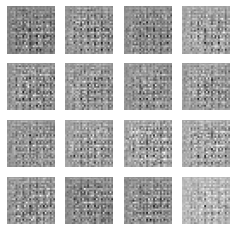

[50/1000] D_loss=0.31886 G_loss=0.39359 Total_loss = 0.71246


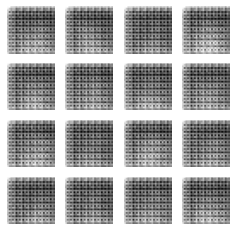

[100/1000] D_loss=0.41033 G_loss=0.35454 Total_loss = 0.76487


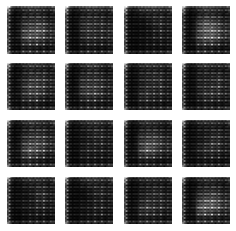

[150/1000] D_loss=0.44829 G_loss=0.32612 Total_loss = 0.77442


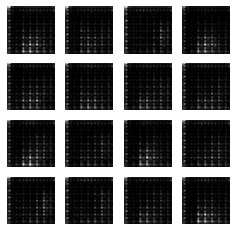

[200/1000] D_loss=0.46511 G_loss=0.31225 Total_loss = 0.77736


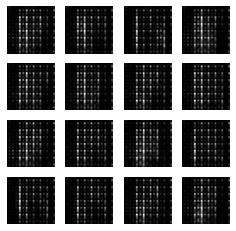

[250/1000] D_loss=0.46830 G_loss=0.30716 Total_loss = 0.77546


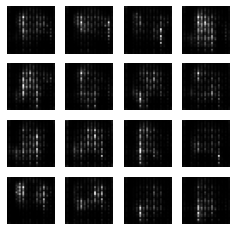

[300/1000] D_loss=0.48796 G_loss=0.30412 Total_loss = 0.79208


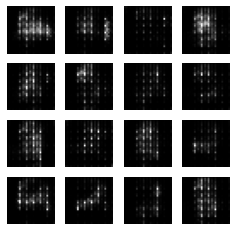

[350/1000] D_loss=0.48769 G_loss=0.29039 Total_loss = 0.77808


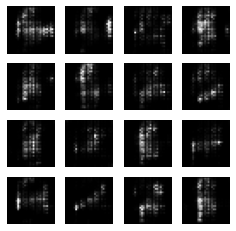

[400/1000] D_loss=0.47625 G_loss=0.29539 Total_loss = 0.77164


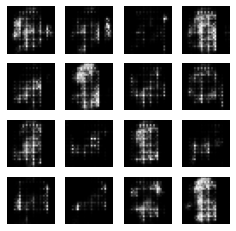

[450/1000] D_loss=0.49125 G_loss=0.28387 Total_loss = 0.77512


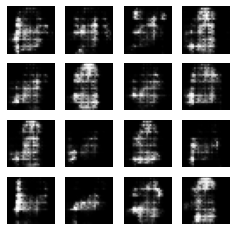

[500/1000] D_loss=0.47971 G_loss=0.28884 Total_loss = 0.76856


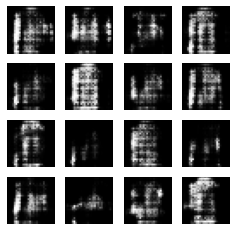

[550/1000] D_loss=0.45452 G_loss=0.30773 Total_loss = 0.76226


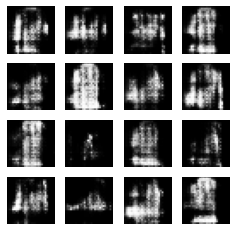

[600/1000] D_loss=0.44838 G_loss=0.31013 Total_loss = 0.75851


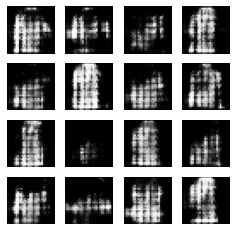

[650/1000] D_loss=0.43477 G_loss=0.32555 Total_loss = 0.76032


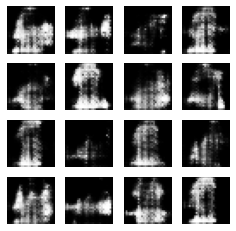

[700/1000] D_loss=0.41026 G_loss=0.34277 Total_loss = 0.75303


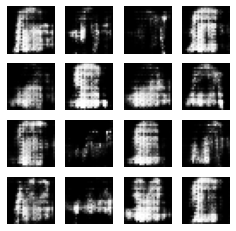

[750/1000] D_loss=0.43044 G_loss=0.33738 Total_loss = 0.76782


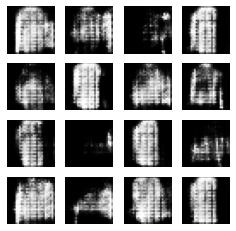

[800/1000] D_loss=0.41429 G_loss=0.33577 Total_loss = 0.75006


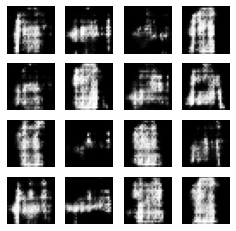

[850/1000] D_loss=0.41210 G_loss=0.35340 Total_loss = 0.76550


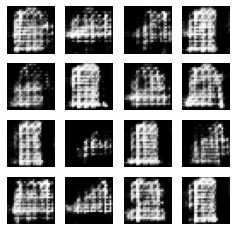

[900/1000] D_loss=0.39147 G_loss=0.37564 Total_loss = 0.76711


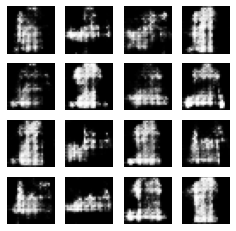

[950/1000] D_loss=0.38047 G_loss=0.38542 Total_loss = 0.76589


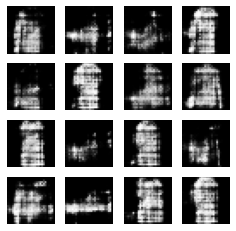

In [19]:
train(train_ds)

In [20]:
# import tensorflow as tf
# from tensorflow.keras import layers

# import numpy as np

# # metrics setting
# g_loss_metrics = tf.metrics.Mean(name='g_loss')
# d_loss_metrics = tf.metrics.Mean(name='d_loss')
# total_loss_metrics = tf.metrics.Mean(name='total_loss')

# # hyper-parameters
# ITERATION = 10000
# Z_DIM = 100
# BATCH_SIZE = 512
# BUFFER_SIZE = 60000
# D_LR = 0.0002
# G_LR = 0.0002
# IMAGE_SHAPE = (28, 28, 1)
# RANDOM_SEED = 42

# np.random.seed(RANDOM_SEED)
# tf.random.set_seed(RANDOM_SEED)

# test_z = tf.random.normal([16, Z_DIM])


# def get_random_z(z_dim, batch_size):
#     return tf.random.uniform([batch_size, z_dim], minval=-1, maxval=1)


# # define discriminator
# def make_discriminaor(input_shape):
#     return tf.keras.Sequential([
#         layers.Conv2D(64, 5, strides=2, padding='same',
#                       input_shape=input_shape),
#         layers.LeakyReLU(),
#         layers.Dropout(0.3),
#         layers.Conv2D(128, 5, strides=2, padding='same'),
#         layers.LeakyReLU(),
#         layers.Dropout(0.3),
#         layers.Flatten(),
#         layers.Dense(1)
#     ])


# # define generator
# def make_generator(input_shape):
#     return tf.keras.Sequential([
#         layers.Dense(7*7*256, use_bias=False, input_shape=input_shape),
#         layers.BatchNormalization(),
#         layers.LeakyReLU(),
#         layers.Reshape((7, 7, 256)),
#         layers.Conv2DTranspose(
#             128, 5, strides=1, padding='same', use_bias=False),
#         layers.BatchNormalization(),
#         layers.LeakyReLU(),
#         layers.Conv2DTranspose(
#             64, 5, strides=2, padding='same', use_bias=False),
#         layers.BatchNormalization(),
#         layers.LeakyReLU(),
#         layers.Conv2DTranspose(
#             1, 5, strides=2, padding='same', use_bias=False, activation='tanh')
#     ])


# # define loss function
# def get_loss_fn():
#     # Least Squared Error
#     criterion = tf.keras.losses.MeanSquaredError()

#     def d_loss_fn(real_logits, fake_logits):
#         real_loss = criterion(tf.ones_like(real_logits), real_logits)
#         fake_loss = criterion(tf.zeros_like(fake_logits), fake_logits)
#         return real_loss + fake_loss

#     def g_loss_fn(fake_logits):
#         return criterion(tf.ones_like(fake_logits), fake_logits)

#     return d_loss_fn, g_loss_fn


# # data load & preprocessing
# (train_x, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
# train_x = train_x.reshape(train_x.shape[0], 28, 28, 1)
# train_x = (train_x - 127.5) / 127.5
# train_ds = (
#     tf.data.Dataset.from_tensor_slices(train_x)
#     .shuffle(BUFFER_SIZE)
#     .batch(BATCH_SIZE, drop_remainder=True)
#     .repeat()
# )

# # generator & discriminator
# G = make_generator((Z_DIM,))
# D = make_discriminaor(IMAGE_SHAPE)

# # optimizer
# g_optim = tf.keras.optimizers.Adam(G_LR, beta_1=0.5, beta_2=0.999)
# d_optim = tf.keras.optimizers.Adam(D_LR, beta_1=0.5, beta_2=0.999)

# # loss function
# d_loss_fn, g_loss_fn = get_loss_fn()


# @tf.function
# def train_step(real_images):
#     z = get_random_z(Z_DIM, BATCH_SIZE)
#     with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
#         fake_images = G(z, training=True)

#         fake_logits = D(fake_images, training=True)
#         real_logits = D(real_images, training=True)

#         d_loss = d_loss_fn(real_logits, fake_logits)
#         g_loss = g_loss_fn(fake_logits)

#     d_gradients = d_tape.gradient(d_loss, D.trainable_variables)
#     g_gradients = g_tape.gradient(g_loss, G.trainable_variables)

#     d_optim.apply_gradients(zip(d_gradients, D.trainable_variables))
#     g_optim.apply_gradients(zip(g_gradients, G.trainable_variables))

#     return g_loss, d_loss


# # training loop
# def train(ds, log_freq=20, test_freq=1000):
#     ds = iter(ds)
#     for step in range(ITERATION):
#         images = next(ds)
#         g_loss, d_loss = train_step(images)

#         g_loss_metrics(g_loss)
#         d_loss_metrics(d_loss)
#         total_loss_metrics(g_loss + d_loss)

#         if step % log_freq == 0:
#             template = '[{}/{}] D_loss={:.5f} G_loss={:.5f} Total_loss={:.5f}'
#             print(template.format(step, ITERATION, d_loss_metrics.result(),
#                                   g_loss_metrics.result(), total_loss_metrics.result()))
#             g_loss_metrics.reset_states()
#             d_loss_metrics.reset_states()
#             total_loss_metrics.reset_states()
#              result_show(G,test_z)



